In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"

# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous file, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*

## What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Keras Functional API (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - **Model 0**: a transfer learning model using the Keras Functional API
  - **Model 1**: a feature extraction transfer learning model on 1% of the data with data augmentation
  - **Model 2**: a feature extraction transfer learning model on 10% of the data with data augmentation
  - **Model 3**: a fine-tuned transfer learning model on 10% of the data
  - **Model 4**: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard

## Creating helper functions

Throughout our machine learning experiments, we'll likely come across snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And then import the necesary functionality when you need it.

For example, you might write:

```
from helper_functions import plot_loss_curves

...

plot_loss_curves(history)
```

In [2]:
import wget

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

file = wget.download(url)

In [3]:
from helper_functions import plot_loss_curves, create_tensorboard_callback, walk_through_dir, unzip_data

## 10 Food Classes: Working with less data

We saw in the previous notebook that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

Finally, we'll also be practicing using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

In [4]:
# Downloading The Data:

import wget

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

file = wget.download(url)

In [5]:
# Unzipping The data Using unzip_dta from Helper Functions:

unzip_data("10_food_classes_10_percent.zip")

In [6]:
# Walking Through Data Directory Using walk_through_dir Function from Helper Functions:

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [7]:
# Creating Training and Test Directory Paths:

train_dir = "10_food_classes_10_percent\\train\\"
test_dir = "10_food_classes_10_percent\\test\\"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class.

However, as of August 2023, this class is deprecated and isn't recommended for future usage (it's too slow).

Because of this, we'll move onto using `tf.keras.utils.image_dataset_from_directory()`.

This method expects image data in the following file format:

```
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

One of the main benefits of using [`tf.keras.prepreprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) rather than `ImageDataGenerator` is that it creates a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object rather than a generator.

The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.

In [8]:
# Creating Training and testing Data Inputs:

import tensorflow as tf
IMG_SHAPE = (224,224) # Target Image Size to feed into Models

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size= IMG_SHAPE,
                                                                           label_mode= "categorical",
                                                                           batch_size= 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size= IMG_SHAPE,
                                                               label_mode= "categorical",
                                                               batch_size= 32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the `image_dataset_from_directory()` funtion are:
* `directory` - the filepath of the target directory we're loading images in from.
* `image_size` - the target size of the images we're going to load in (height, width).
* `batch_size` - the batch size of the images we're going to load in. For example if the `batch_size` is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

There are more we could play around with if we needed to [in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

In [9]:
# Checking out Training Data:

train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

* `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and `3` is the color channels (red, green, blue).
* `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [10]:
# Checking Out Class Names of Our Dataset:

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# Seeing Example of Training Data:

for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[192.64285   201.64285   244.64285  ]
   [189.14285   198.14285   241.14285  ]
   [192.92856   201.92856   244.92856  ]
   ...
   [190.        201.        246.       ]
   [190.28572   201.28572   246.28572  ]
   [189.64285   200.64285   245.64285  ]]

  [[192.07143   201.07143   244.07143  ]
   [189.14285   198.14285   241.14285  ]
   [191.92857   200.92857   243.92857  ]
   ...
   [190.58678   201.58678   246.58678  ]
   [192.        203.        248.       ]
   [191.59691   202.59691   247.59691  ]]

  [[191.64285   200.64285   243.64285  ]
   [191.07143   200.07143   243.07143  ]
   [194.57144   203.57144   246.57144  ]
   ...
   [190.2602    201.2602    246.2602   ]
   [190.80103   201.80103   246.80103  ]
   [191.29082   202.29082   247.29082  ]]

  ...

  [[150.13774   149.13774   189.13774  ]
   [151.19896   150.19896   190.19896  ]
   [151.95409   151.        190.90817  ]
   ...
   [ 34.785736   52.35721    26.357208 ]
   [ 40.85724    58.85724    32.85724  ]
   [ 

Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. `[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]` for `hamburger`).

### Model 0: Building a transfer learning model using the Keras Functional API

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0) from [`tf.keras.applications.efficientnet_v2`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2), setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1.

As of writing, the `EfficientNet` (and `EfficientNetV2`) models in the `tf.keras.applications` module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do.

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

### Model 0 : Building a Transfer Learning Feature Extraction Model Using Keras Functional API:

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [13]:
# 1. Create base model with tf.keras.applications:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)

# 2. Freeze Layers in The Base Model (Underlying Pre-Trained Weights aren't Changed During Training):
base_model.trainable = False

# 3. Create Inputs into The Base Model:
inputs = Input(shape= (224,224,3), name= "Input_Layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.Rescaling(1./255)(inputs)

# 5. Pass The Inputs to the Base Model:
x = base_model(inputs)
print(f" Shape after Passing Input Through Base Model: {x.shape}")

# 6. Average Pool The Output of The Base Model (aggregate all the most important information, reduce number of computations)
x = GlobalAveragePooling2D(name= "Gobal_Average_Pooling_Layer")(x)
print(f"Shape after Global Average Pooling: {x.shape}")

# 7. Create The Output Activation Layer:
outputs = Dense(10, activation= "softmax", name= "Output_Layer")(x)

# 8. Combine Inputs with The Outputs Into The Model:
model_0 = Model(inputs, outputs)

# 9. Compile The Model:
model_0.compile(optimizer= Adam(),
               loss= CategoricalCrossentropy(),
               metrics= ["accuracy"])

# Fit The Model:
history_0_10_percent = model_0.fit(train_data_10_percent,
                                  epochs= 5,
                                  validation_data= test_data,
                                  callbacks= [create_tensorboard_callback("Transfer Learning", "10_percent_feature_extract")])



 Shape after Passing Input Through Base Model: (None, 7, 7, 1280)
Shape after Global Average Pooling: (None, 1280)
Saving TensorBoard log files to: Transfer Learning/10_percent_feature_extract/20240506-121642
Epoch 1/5


24/24 [==============================] - 67s 1s/step - loss: 1.9853 - accuracy: 0.3120 - val_loss: 1.4100 - val_accuracy: 0.6804
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 1.2123 - accuracy: 0.7253 - val_loss: 0.9430 - val_accuracy: 0.8008
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.8827 - accuracy: 0.8013 - val_loss: 0.7489 - val_accuracy: 0.8296
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.7104 - accuracy: 0.8467 - val_loss: 0.6485 - val_accuracy: 0.8456
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.6088 - accuracy: 0.8627 - val_loss: 0.5851 - val_accuracy: 0.8524


This is incredible.

All thanks to the power of transfer learning!

It's important to note the kind of transfer learning we used here is called feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetV2B0`), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

To see the benefits and use cases of the Functional API versus the Sequential API, check out the [TensorFlow Functional API documentation](https://www.tensorflow.org/guide/keras/functional).

In [16]:
# Checking Out Layers of Base Model:
base_model.layers

In [17]:
type(base_model.layers)

list

In [19]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [20]:
# Model Summary:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

 block3b_expand_activation   (None, None, None, 192)      0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_project_conv (Conv  (None, None, None, 48)       9216      ['block3b_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block3b_project_bn (BatchN  (None, None, None, 48)       192       ['block3b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_drop (Dropout)      (None, None, None, 48)       0         ['block3b_project_bn[0][0]']  
          

 2D)                                                                                              
                                                                                                  
 block4b_project_bn (BatchN  (None, None, None, 96)       384       ['block4b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_drop (Dropout)      (None, None, None, 96)       0         ['block4b_project_bn[0][0]']  
                                                                                                  
 block4b_add (Add)           (None, None, None, 96)       0         ['block4b_drop[0][0]',        
                                                                     'block4a_project_bn[0][0]']  
                                                                                                  
 block4c_e

 block5a_project_conv (Conv  (None, None, None, 112)      64512     ['block5a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5a_project_bn (BatchN  (None, None, None, 112)      448       ['block5a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5b_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block5b_expand_bn (BatchNo  (None, None, None, 672)      2688      ['block5b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block5c_drop (Dropout)      (None, None, None, 112)      0         ['block5c_project_bn[0][0]']  
                                                                                                  
 block5c_add (Add)           (None, None, None, 112)      0         ['block5c_drop[0][0]',        
                                                                     'block5b_add[0][0]']         
                                                                                                  
 block5d_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5d_e

 block5e_project_bn (BatchN  (None, None, None, 112)      448       ['block5e_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5e_drop (Dropout)      (None, None, None, 112)      0         ['block5e_project_bn[0][0]']  
                                                                                                  
 block5e_add (Add)           (None, None, None, 112)      0         ['block5e_drop[0][0]',        
                                                                     'block5d_add[0][0]']         
                                                                                                  
 block6a_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5e_add[0][0]']         
 D)                                                                                               
          

                                                                                                  
 block6b_add (Add)           (None, None, None, 192)      0         ['block6b_drop[0][0]',        
                                                                     'block6a_project_bn[0][0]']  
                                                                                                  
 block6c_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6c_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_e

 block6d_drop (Dropout)      (None, None, None, 192)      0         ['block6d_project_bn[0][0]']  
                                                                                                  
 block6d_add (Add)           (None, None, None, 192)      0         ['block6d_drop[0][0]',        
                                                                     'block6c_add[0][0]']         
                                                                                                  
 block6e_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6e_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 block6f_drop (Dropout)      (None, None, None, 192)      0         ['block6f_project_bn[0][0]']  
                                                                                                  
 block6f_add (Add)           (None, None, None, 192)      0         ['block6f_drop[0][0]',        
                                                                     'block6e_add[0][0]']         
                                                                                                  
 block6g_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6f_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6g_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6g_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block6h_drop (Dropout)      (None, None, None, 192)      0         ['block6h_project_bn[0][0]']  
                                                                                                  
 block6h_add (Add)           (None, None, None, 192)      0         ['block6h_drop[0][0]',        
                                                                     'block6g_add[0][0]']         
                                                                                                  
 top_conv (Conv2D)           (None, None, None, 1280)     245760    ['block6h_add[0][0]']         
                                                                                                  
 top_bn (BatchNormalization  (None, None, None, 1280)     5120      ['top_conv[0][0]']            
 )        

You can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model, you can think of all of these parameters are patterns the base model has learned on another dataset. And because we set `base_model.trainable = False`, these patterns remain as they are during training (they're frozen and don't get updated).

In [21]:
# Summary of Whole Model:

model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Gobal_Average_Pooling_Laye  (None, 1280)              0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 Output_Layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


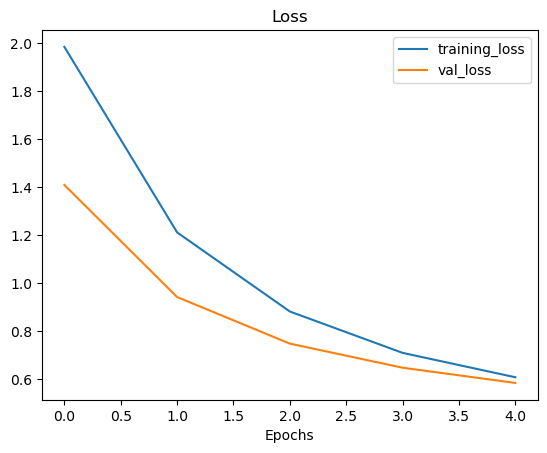

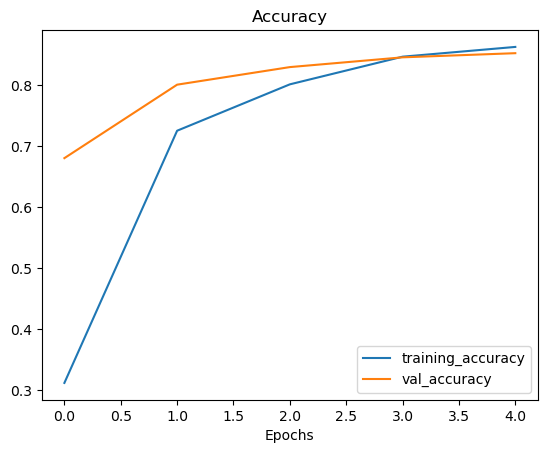

In [22]:
# Model's Loss and Accuracy Curves:
plot_loss_curves(history_0_10_percent)

## Getting a feature vector from a trained model

Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer?

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

In [26]:
# Defining a Input Tensor Shape (Same Number of Dimensions as The Output of efficientnet_v2.EfficientNetV2B0):
input_shape = (1,4,4,3)

# Creating a Random Tensor:
tf.random.set_seed(42)
input_tensor = tf.random.normal(shape= input_shape)
print(f"Random Input Tensor:\n {input_tensor} \n")

# pass the Random tensor Through Global Average Pooling 2D Layer:
global_average_pooled_tensor = GlobalAveragePooling2D()(input_tensor)
print(f"Global Average Pooled Random Tensor:\n {global_average_pooled_tensor}\n")

# Shapes of Both Tensors:
print(f"Shape of Random Input Tensor: {input_tensor.shape}")
print(f"Shape of Average Global Pooled Layer: {global_average_pooled_tensor.shape}")

Random Input Tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]] 

Global Average Pooled Random Tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of Random Input Tensor: (1, 4, 4, 3)
Shape of Average Global Pooled Layer: (1, 3)


You can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed the input tensor from shape `(1, 4, 4, 3)` to `(1, 3)`. It did so by averaging the `input_tensor` across the middle two axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifying the appropriate axes.

In [27]:
# Replicating Same Operation as GlobalAveragePooling2D():
tf.reduce_mean(input_tensor, axis= [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer) which can then be used to extract patterns out of.

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. **Model 1**: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. **Model 2**: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. **Model 3**: Fine-tune the **Model 2** checkpoint on 10% of the training data with data augmentation.
4. **Model 4**: Fine-tune the **Model 2** checkpoint on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the **same test dataset**, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetV2B0` model within the `tf.keras.applications.efficientnet_v2` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [30]:
# Downloading The Data:
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"
file = wget.download(url)

In [31]:
# Unzipping The Data:
unzip_data("10_food_classes_1_percent.zip")

In [32]:
# Creating Training and Testing Data Directories Paths:
train_dir_1_percent = "10_food_classes_1_percent\\train\\"
test_dir = "10_food_classes_1_percent\\test\\"

In [33]:
# Walking Through 1 Percent Directory:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [35]:
# Creating Training and Testing Data Loaders (Inputs):

IMG_SHAPE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          image_size= IMG_SHAPE,
                                                                          label_mode= "categorical",
                                                                          batch_size= 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size= IMG_SHAPE,
                                                               label_mode= "categorical",
                                                               batch_size= 32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

Using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.10+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

> 📚 **Resource:** For more information on different methods of data augmentation, check out the the [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:
* [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) - flips image on horizontal or vertical axis.
* [`tf.keras.layers.RandomRotation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) - randomly rotates image by a specified amount.
* [`tf.keras.layers.RandomZoom`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) - randomly zooms into an image by specified amount.
* [`tf.keras.layers.RandomHeight`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomHeight) - randomly shifts image height by a specified amount.
* [`tf.keras.layers.RandomWidth`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomWidth) - randomly shifts image width by a specified amount.
* [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using [`tf.keras.applications.efficientnet_v2.EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0), it's not required (the model pretrained model implements rescaling itself).


In [36]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Rescaling

In [38]:
# Creating a Sequential Model to add All Image Augmentation Layers together:

data_augmentation = Sequential(name= "Data_Augmentation")
data_augmentation.add(RandomFlip(mode= "horizontal"))
data_augmentation.add(RandomRotation(factor= 0.2))
data_augmentation.add(RandomZoom(height_factor= 0.2))
data_augmentation.add(RandomHeight(factor= 0.2))
data_augmentation.add(RandomWidth(factor= 0.2))
# data_augmentation.add(Rescaling(1/255)) # keep for ResNet50V2, remove for EfficientNetV2B0

Our data augmentation Sequential model is ready to go. As you'll see shortly, we'll be able to slot this "model" as a layer into our transfer learning model later on.

But before we do that, let's test it out by passing random images through it.

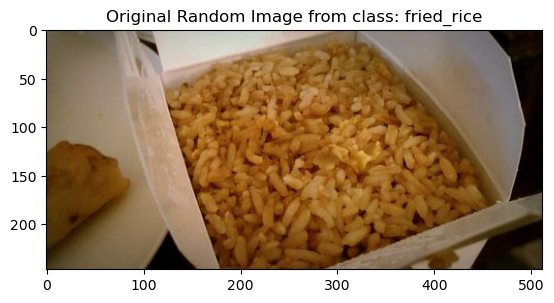

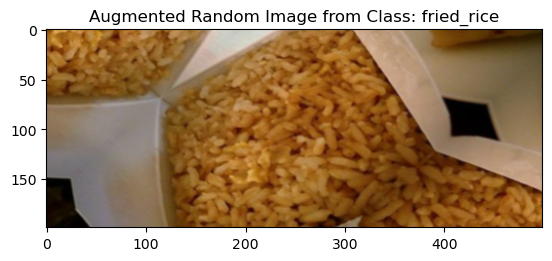

In [68]:
# View a Random Image after Applying Data Augmentation on it:

import matplotlib.pyplot as plt
import os
import random

target_class = random.choice(train_data_1_percent.class_names) # Chose a Random Class
target_dir = "10_food_classes_1_percent\\train\\" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "\\" + random_image
image = plt.imread(random_image_path)
plt.imshow(image)
plt.title(f"Original Random Image from class: {target_class}")
plt.show()

# Augment The Image:
augmented_image = data_augmentation(tf.expand_dims(image, axis= 0)) # data augmentation model requires shape (None, height, width, 3)
plt.imshow(tf.squeeze(augmented_image)/255) # requires normalization after augmentation
plt.title(f"Augmented Random Image from Class: {target_class}")
plt.show()

Run the cell above a few times and you can see the different random augmentations on different classes of images. Because we're going to add the data augmentation model as a layer in our upcoming transfer learning model, it'll apply these kind of random augmentations to each of the training images which passes through it.

Doing this will make our training dataset a little more varied. You can think of it as if you were taking a photo of food in real-life, not all of the images are going to be perfect, some of them are going to be orientated in strange ways. These are the kind of images we want our model to be able to handle.

Speaking of model, let's build one with the Functional API. We'll run through all of the same steps as before except for one difference, we'll add our data augmentation Sequential model as a layer immediately after the input layer.

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [69]:
# Setting Up Input Shape and Base Model, freezing The Base Model Layers:
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)
base_model.trainable = False

# Creating Input Layer:
inputs = Input(shape= input_shape, name= "Input_Layer")

# Add in Data Augmentation Sequential Model as a Layer in the Model:
x = data_augmentation(inputs)

# Give base_model inputs after augmentation and don't train it:
x = base_model(x)

# Pool Output Features of Base Model:
x = GlobalAveragePooling2D(name= "Golbal_Average_Pooling_Layer")(x)

# Put a Dense Layer on as the output:
outputs =  Dense(10, activation= "softmax", name= "Output_Layer")(x)

# Make a Model With Inputs and Outputs:
model_1 = Model(inputs, outputs)

# Compile The Model:
model_1.compile(optimizer= Adam(),
               loss= CategoricalCrossentropy(),
               metrics= ["accuracy"])

# Fit The Model:
history_1_percent = model_1.fit(train_data_1_percent,
                               validation_data= test_data,
                               epochs= 5,
                               callbacks= [create_tensorboard_callback(dir_name= "Transfer Learning",
                                                                      experiment_name= "1_percent_data_aug")])

Saving TensorBoard log files to: Transfer Learning/1_percent_data_aug/20240506-153247
Epoch 1/5
3/3 [==============================] - 25s 7s/step - loss: 2.3205 - accuracy: 0.1143 - val_loss: 2.2149 - val_accuracy: 0.1484
Epoch 2/5
3/3 [==============================] - 9s 4s/step - loss: 2.1084 - accuracy: 0.2714 - val_loss: 2.1006 - val_accuracy: 0.2448
Epoch 3/5
3/3 [==============================] - 9s 4s/step - loss: 1.9485 - accuracy: 0.3571 - val_loss: 1.9969 - val_accuracy: 0.3432
Epoch 4/5
3/3 [==============================] - 9s 4s/step - loss: 1.8336 - accuracy: 0.4571 - val_loss: 1.9065 - val_accuracy: 0.4148
Epoch 5/5
3/3 [==============================] - 9s 5s/step - loss: 1.7106 - accuracy: 0.5571 - val_loss: 1.8238 - val_accuracy: 0.4776


Using only 7 training images per class, using transfer learning our model was able to get ~45%+ accuracy on the validation set.

This result is pretty amazing since the [original Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) achieved 50.67% accuracy with all the data, namely, 750 training images per class (**note:** this metric was across 101 classes, not 10, we'll get to 101 classes soon).

If we check out a summary of our model, we should see the data augmentation layer just after the input layer.

In [70]:
# Summary of The Model:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Golbal_Average_Pooling_Lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 Output_Layer (Dense)        (None, 10)                1281

We've now got data augmentation built right into the our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is **data augmentation only runs during training**. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

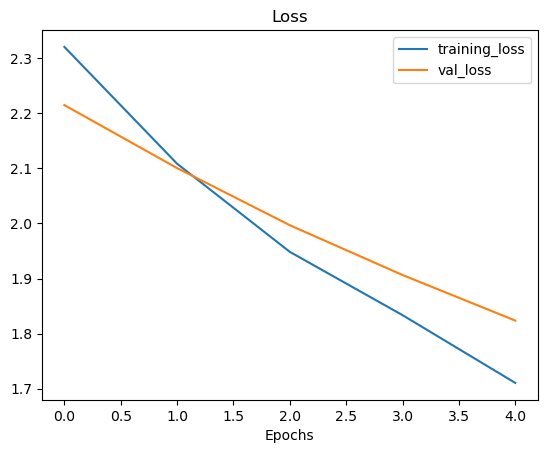

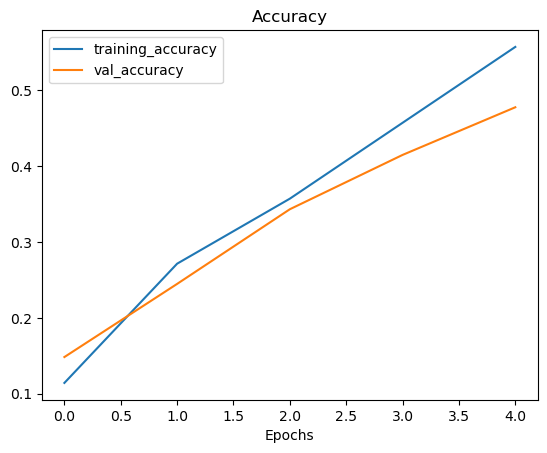

In [71]:
# Pltting Loss Curves of Model:
plot_loss_curves(history_1_percent)

It looks like the metrics on both datasets would improve if we kept training for more epochs.

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

How to you know what experiments to run?

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that we'll start to develop an intuition of what to try.

My advice is to follow your curiosity as tenaciously as possible. If you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

In [72]:
# Setting up Training and Testinf Data Directory Paths:
train_dir_10_percent = "10_food_classes_10_percent\\train\\"
test_dir = "10_food_classes_10_percent\\test\\"

In [73]:
# Setting Up Data Loaders:
IMG_SHAPE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           image_size= IMG_SHAPE,
                                                                           label_mode= "categorical",
                                                                           batch_size= 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size= IMG_SHAPE,
                                                               label_mode= "categorical",
                                                               batch_size= 32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [74]:
# Creating a Functional Model with Data Augmentation Sequential Model as a Layer:

data_augmentation = Sequential(name= "Data_Augmentation")
data_augmentation.add(RandomFlip("horizontal"))
data_augmentation.add(RandomRotation(0.2))
data_augmentation.add(RandomZoom(0.2))
data_augmentation.add(RandomHeight(0.2))
data_augmentation.add(RandomWidth(0.2))
# data_augmentation.add(Rescaling(1/255)) # keep for ResNet50V2, remove for EfficientNetV2B0

# Setting Up Base Model and Input Shapes:
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)
base_model.trainable = False

# Creating Input and Output layers:
inputs = Input(shape= input_shape, name= "Input_Layer")
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = GlobalAveragePooling2D(name= "Global_Average_Pooling_layer")(x)
outputs = Dense(10, activation= "softmax", name= "Output_Layer")(x)
model_2 = Model(inputs, outputs)

# Compiling The Model:
model_2.compile(optimizer= Adam(),
               loss= CategoricalCrossentropy(),
               metrics= ["accuracy"])

In [75]:
# Summary of The Model:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Global_Average_Pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 Output_Layer (Dense)        (None, 10)                1281

### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

Let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [76]:
# Set Checkpoint Path:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a Model Checkpoint Callback That Save Model's Weights Only:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                                        save_weights_only= True,
                                                        save_freq= "epoch", verbose= 1)

What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

In [77]:
# Fitting The model_2 saving Checkpoints every Epoch:

initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                         validation_data= test_data,
                                         epochs= initial_epochs,
                                         callbacks= [create_tensorboard_callback(dir_name= "Transfer Learning",
                                                                      experiment_name= "10_percent_data_aug"),
                                                    checkpoint_callback])

Saving TensorBoard log files to: Transfer Learning/10_percent_data_aug/20240506-161357
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9936 - accuracy: 0.3400
Epoch 1: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 27s 726ms/step - loss: 1.9936 - accuracy: 0.3400 - val_loss: 1.5064 - val_accuracy: 0.6040
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3922 - accuracy: 0.6507
Epoch 2: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 12s 521ms/step - loss: 1.3922 - accuracy: 0.6507 - val_loss: 1.0732 - val_accuracy: 0.7428
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1000 - accuracy: 0.7133
Epoch 3: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 12s 516ms/step - loss: 1.1000 - accuracy: 0.7133 - val_loss: 0.8593 - val_accuracy: 0.7912
E

In [78]:
# Saving validation Accuracy of all Model:
result_10_percent = model_0.evaluate(test_data)
result_1_percent_data_aug = model_1.evaluate(test_data)
result_10_percent_data_aug = model_2.evaluate(test_data)

print(result_10_percent)
print(result_1_percent_data_aug)
print(result_10_percent_data_aug)

79/79 [==============================] - 9s 108ms/step - loss: 0.6692 - accuracy: 0.8236
[0.5851309299468994, 0.852400004863739]
[1.8237998485565186, 0.47760000824928284]
[0.6691526770591736, 0.8235999941825867]


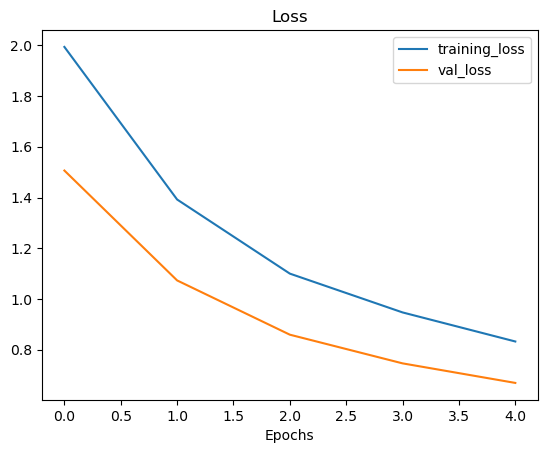

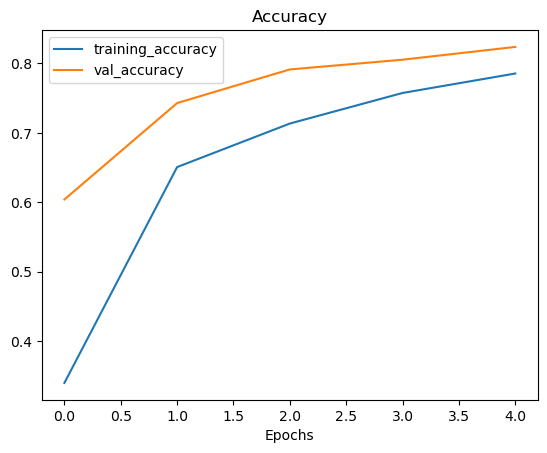

In [79]:
# Plotting Loss and Accuracy Curves of Model_2:
plot_loss_curves(history_10_percent_data_aug)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see `model_0` results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) method, passing it the path where your saved weights are stored.

In [80]:
# Loading In Saved Model Weights and Evaluating The Model:
model_2.load_weights(checkpoint_path)
result_loaded_weights_model = model_2.evaluate(test_data)

79/79 [==============================] - 9s 110ms/step - loss: 0.6692 - accuracy: 0.8236


In [81]:
result_10_percent_data_aug == result_loaded_weights_model

False

If the above cell doesn't output `True`, it's because the numbers are close but not the *exact* same (due to how computers store numbers with degrees of precision).

However, they should be *very* close.

## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (`EfficientNetV2B0`) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

We've verified our loaded model's performance, let's check out its layers.

In [82]:
# layers in our Loaded Model_2:

model_2.layers

In [83]:
for layer_number, layer in enumerate(model_2.layers):
    print(f"Layer Number: {layer_number} | Layer Name: {layer.name} | Trainable?: {layer.trainable}")

Layer Number: 0 | Layer Name: Input_Layer | Trainable?: True
Layer Number: 1 | Layer Name: Data_Augmentation | Trainable?: True
Layer Number: 2 | Layer Name: efficientnetv2-b0 | Trainable?: False
Layer Number: 3 | Layer Name: Global_Average_Pooling_layer | Trainable?: True
Layer Number: 4 | Layer Name: Output_Layer | Trainable?: True


In [85]:
# Layers in Base Model:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(f"Layer Number: {layer_number} | Layer Name: {layer.name} | Trainable?: {layer.trainable}")

Layer Number: 0 | Layer Name: input_3 | Trainable?: False
Layer Number: 1 | Layer Name: rescaling_2 | Trainable?: False
Layer Number: 2 | Layer Name: normalization_2 | Trainable?: False
Layer Number: 3 | Layer Name: stem_conv | Trainable?: False
Layer Number: 4 | Layer Name: stem_bn | Trainable?: False
Layer Number: 5 | Layer Name: stem_activation | Trainable?: False
Layer Number: 6 | Layer Name: block1a_project_conv | Trainable?: False
Layer Number: 7 | Layer Name: block1a_project_bn | Trainable?: False
Layer Number: 8 | Layer Name: block1a_project_activation | Trainable?: False
Layer Number: 9 | Layer Name: block2a_expand_conv | Trainable?: False
Layer Number: 10 | Layer Name: block2a_expand_bn | Trainable?: False
Layer Number: 11 | Layer Name: block2a_expand_activation | Trainable?: False
Layer Number: 12 | Layer Name: block2a_project_conv | Trainable?: False
Layer Number: 13 | Layer Name: block2a_project_bn | Trainable?: False
Layer Number: 14 | Layer Name: block2b_expand_conv | Tr

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

> 📖 **Resource:** The [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146) has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire `model_2_base_model` by setting its `trainable` attribute to `True`.

Then we'll refreeze every layer in `model_2_base_model` except for the last 10 by looping through them and setting their `trainable` attribute to `False`.

Finally, we'll recompile the whole model.

In [86]:
# Unfreezing all Layers in Base Model:
base_model.trainable= True

# Freeze all Layers Except Last 10:
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [90]:
# recompile The Model:
model_2.compile(optimizer= Adam(),
               loss= CategoricalCrossentropy(0.0001), # lr is 10x lower than before for fine-tuning
               metrics= ["accuracy"])

In [91]:
# Checking Which Layers are trainable in Base_Model:
for layer_number,layer in enumerate(model_2.layers[2].layers):
    print(f"Layer Number: {layer_number} | Layer Name: {layer.name} | Trainable?: {layer.trainable}")

Layer Number: 0 | Layer Name: input_3 | Trainable?: False
Layer Number: 1 | Layer Name: rescaling_2 | Trainable?: False
Layer Number: 2 | Layer Name: normalization_2 | Trainable?: False
Layer Number: 3 | Layer Name: stem_conv | Trainable?: False
Layer Number: 4 | Layer Name: stem_bn | Trainable?: False
Layer Number: 5 | Layer Name: stem_activation | Trainable?: False
Layer Number: 6 | Layer Name: block1a_project_conv | Trainable?: False
Layer Number: 7 | Layer Name: block1a_project_bn | Trainable?: False
Layer Number: 8 | Layer Name: block1a_project_activation | Trainable?: False
Layer Number: 9 | Layer Name: block2a_expand_conv | Trainable?: False
Layer Number: 10 | Layer Name: block2a_expand_bn | Trainable?: False
Layer Number: 11 | Layer Name: block2a_expand_activation | Trainable?: False
Layer Number: 12 | Layer Name: block2a_project_conv | Trainable?: False
Layer Number: 13 | Layer Name: block2a_project_bn | Trainable?: False
Layer Number: 14 | Layer Name: block2b_expand_conv | Tr

It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

Why did we recompile the model?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (`0.0001` instead of Adam's default of `0.001`).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

There's no set standard for setting the learning rate during fine-tuning, though reductions of [2.6x-10x+ seem to work well in practice](https://arxiv.org/abs/1801.06146).

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. We'll pass it the last epoch of the previous model's training history (`history_10_percent_data_aug.epoch[-1]`).

In [93]:
# Fine Tune for Another 5 Epochs:
fine_tune_eppchs = initial_epochs + 5

# Fitting The Model (same as model_2 except with more trainable layers):
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                              validation_data= test_data,
                                              epochs= fine_tune_eppchs,
                                              initial_epoch= history_10_percent_data_aug.epoch[-1],  # start from previous last epoch
                                            callbacks= [create_tensorboard_callback(dir_name= "Transfer Learning",
                                                                      experiment_name= "10_percent_fine_tune_last_10")])


Saving TensorBoard log files to: Transfer Learning/10_percent_fine_tune_last_10/20240506-170338
Epoch 5/10
24/24 [==============================] - 27s 721ms/step - loss: 0.7761 - accuracy: 0.7573 - val_loss: 0.5012 - val_accuracy: 0.8244
Epoch 6/10
24/24 [==============================] - 13s 533ms/step - loss: 0.4374 - accuracy: 0.8800 - val_loss: 0.5181 - val_accuracy: 0.8276
Epoch 7/10
24/24 [==============================] - 12s 520ms/step - loss: 0.3468 - accuracy: 0.8920 - val_loss: 0.4214 - val_accuracy: 0.8616
Epoch 8/10
24/24 [==============================] - 13s 543ms/step - loss: 0.2497 - accuracy: 0.9200 - val_loss: 0.5092 - val_accuracy: 0.8500
Epoch 9/10
24/24 [==============================] - 14s 607ms/step - loss: 0.2282 - accuracy: 0.9253 - val_loss: 0.4269 - val_accuracy: 0.8664
Epoch 10/10
24/24 [==============================] - 14s 608ms/step - loss: 0.1712 - accuracy: 0.9533 - val_loss: 0.4590 - val_accuracy: 0.8644


In [94]:
# Evaluating The Fine Tuned Model and Saving Validation Accuracy:
result_finetune_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 9s 112ms/step - loss: 0.4590 - accuracy: 0.8644


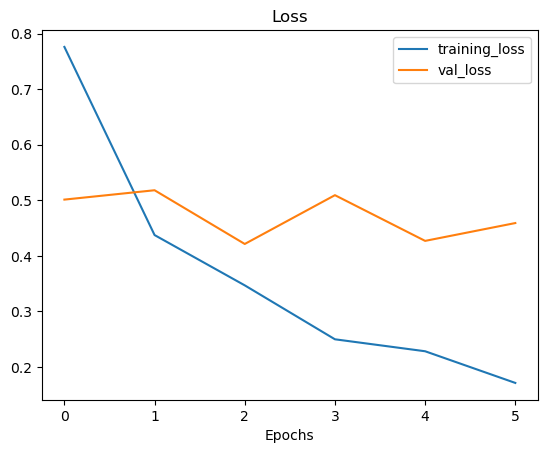

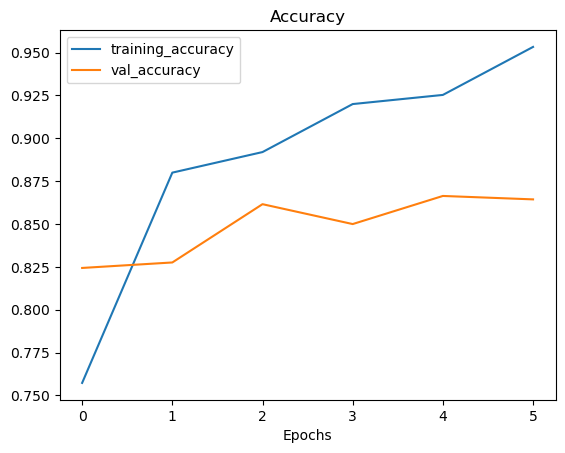

In [95]:
# Plotting Lost and Accuracy of Fine Tuned Model:
plot_loss_curves(history_fine_10_percent_data_aug)

In [100]:
# Creating a Function to Compare Histories of Model after Multiple fit() calls:

def compare_historys(original_history, new_history, initial_epochs= 5):
    """
    Compares two model history objects.
    """
    
    # Get Original Histroy Measurements:
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    # Combine Original History with New History:
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]
    
    # Plotting Accuracy:
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label= "Training Accuracy")
    plt.plot(total_val_acc, label= "Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label= "Start Fine Tuning")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.show()
    
    # Plotting Loss:
    plt.subplot(2,1,1)
    plt.plot(total_loss, label= "Training Loss")
    plt.plot(total_val_loss, label= "Validation Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label= "Start Fine Tuning")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

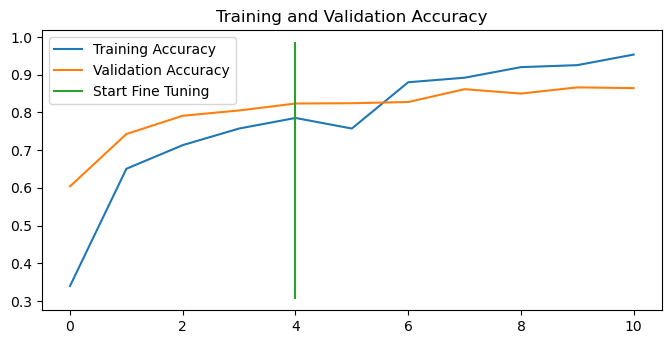

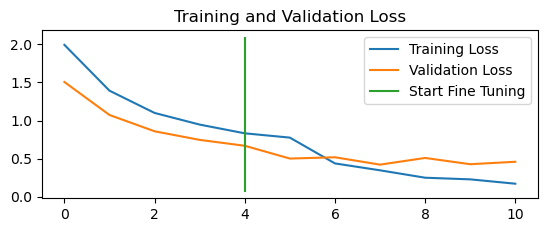

In [101]:
compare_historys(history_10_percent_data_aug, history_fine_10_percent_data_aug)

## Model 4: Fine-tuning an existing model all of the data

In [102]:
# Downloading Data:
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"
file = wget.download(url)

# Unzipping The Data:
unzip_data("10_food_classes_all_data.zip")

In [113]:
# Setting Up Training and Testing Data Directory Paths:
train_dir_all_data = "10_food_classes_all_data\\train\\"
test_dir = "10_food_classes_all_data\\test\\"

In [114]:
# Walking Through The Directory of All Data:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [115]:
# Creating Data Loaders for Input to the Model:
IMG_SHAPE= (224,224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                image_size= IMG_SHAPE,
                                                                                label_mode= "categorical",
                                                                                batch_size= 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size= IMG_SHAPE,
                                                               label_mode= "categorical",
                                                               batch_size= 32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The **test dataset is the same** we've been using for our previous experiments.

As it is now, our `model_2` has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To keep our experiments clean,we"ll revert back model_2 to it's feature extraction state that it was in after first 5 epochs
by loading checkpointed weight back to model_2.

We're trying to measure:
* **Experiment 3 (previous one)** - `model_2` with 10 layers fine-tuned for 5 more epochs on 10% of the data.
* **Experiment 4 (this one)** - `model_2` with layers fined-tuned for 5 more epochs on 100% on the data.

Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (`model_2` feature extractor trained for 5 epochs on 10% of the data).

In [119]:
# Creating and Compiling New Instance of model_2:

# Creating a Functional Model with Data Augmentation Sequential Model as a Layer:

data_augmentation = Sequential(name= "Data_Augmentation")
data_augmentation.add(RandomFlip("horizontal"))
data_augmentation.add(RandomRotation(0.2))
data_augmentation.add(RandomZoom(0.2))
data_augmentation.add(RandomHeight(0.2))
data_augmentation.add(RandomWidth(0.2))
# data_augmentation.add(Rescaling(1/255)) # keep for ResNet50V2, remove for EfficientNetV2B0

# Setting Up Base Model and Input Shapes:
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)
base_model.trainable = False

# Creating Input and Output layers:
inputs = Input(shape= input_shape, name= "Input_Layer")
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = GlobalAveragePooling2D(name= "Global_Average_Pooling_layer")(x)
outputs = Dense(10, activation= "softmax", name= "Output_Layer")(x)
model_2 = Model(inputs, outputs)

# Compiling The Model:
model_2.compile(optimizer= Adam(learning_rate= 0.0001),
               loss= CategoricalCrossentropy(),
               metrics= ["accuracy"])

In [120]:
# Loading Back Weights from Checkpoint:
model_2.load_weights(checkpoint_path)

In [121]:
# Summary of Model:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Global_Average_Pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 Output_Layer (Dense)        (None, 10)                1281

In [122]:
# Evaluating model_2:
model_2.evaluate(test_data)

79/79 [==============================] - 32s 234ms/step - loss: 0.6692 - accuracy: 0.8236


[0.6691526770591736, 0.8235999941825867]

In [124]:
result_10_percent_data_aug

[0.6691526770591736, 0.8235999941825867]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint` (**Model 2**).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (**Model 3**).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (**Model 4**).


We're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [125]:
# Checking Which Models are Trainable:
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 Input_Layer True
1 Data_Augmentation True
2 efficientnetv2-b0 False
3 Global_Average_Pooling_layer True
4 Output_Layer True


In [126]:
# Let's see which layers are Trainable in Base Model:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

So let's unfreeze the last 10 layers of the `base_model` to make them trainable (for fine-tuning).

In [127]:
# Unfreezing All Layers in Base Model:
base_model.trainable = True

# Freezing all Layers in Base Model Except last 10:
for layer in model_2.layers[2].layers[:-10]:
    layer.trainable= False

In [128]:
# Let's see which layers are Trainable in Base Model:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [130]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(optimizer= Adam(0.0001),
               loss= CategoricalCrossentropy(),
               metrics= ["accuracy"])

In [131]:
# Fitting The Model to Fine-Tune:
fine_tune_eppchs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                          validation_data= test_data,
                                          epochs= fine_tune_eppchs,
                                          initial_epoch= history_10_percent_data_aug.epoch[-1],
                                          callbacks=[create_tensorboard_callback(dir_name= "Transfer Learning",
                                                                      experiment_name= "full_10_class_fine_tune_last_10")])

Saving TensorBoard log files to: Transfer Learning/full_10_class_fine_tune_last_10/20240506-190135
Epoch 5/10
235/235 [==============================] - 72s 229ms/step - loss: 0.7293 - accuracy: 0.7699 - val_loss: 0.3883 - val_accuracy: 0.8684
Epoch 6/10
235/235 [==============================] - 54s 230ms/step - loss: 0.5980 - accuracy: 0.8085 - val_loss: 0.3276 - val_accuracy: 0.8876
Epoch 7/10
235/235 [==============================] - 59s 251ms/step - loss: 0.5442 - accuracy: 0.8241 - val_loss: 0.3074 - val_accuracy: 0.8972
Epoch 8/10
235/235 [==============================] - 62s 263ms/step - loss: 0.5096 - accuracy: 0.8345 - val_loss: 0.2953 - val_accuracy: 0.8956
Epoch 9/10
235/235 [==============================] - 66s 281ms/step - loss: 0.4812 - accuracy: 0.8444 - val_loss: 0.2798 - val_accuracy: 0.9060
Epoch 10/10
235/235 [==============================] - 68s 289ms/step - loss: 0.4568 - accuracy: 0.8508 - val_loss: 0.2655 - val_accuracy: 0.9144


In [132]:
# Evaluating The Model:
result_finetune_all_data = model_2.evaluate(test_data)

79/79 [==============================] - 13s 163ms/step - loss: 0.2655 - accuracy: 0.9144


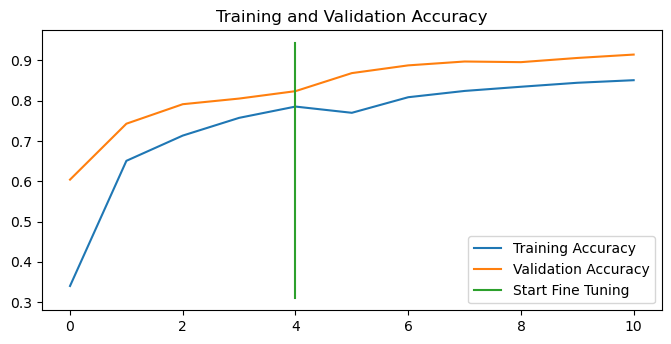

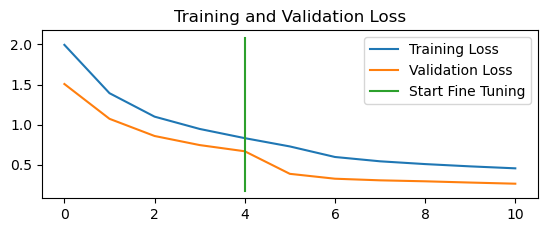

In [133]:
# Comparing Feature Extractor model_2 and Fine Tuned model_2:
compare_historys(history_10_percent_data_aug, history_fine_10_classes_full, initial_epochs= 5)

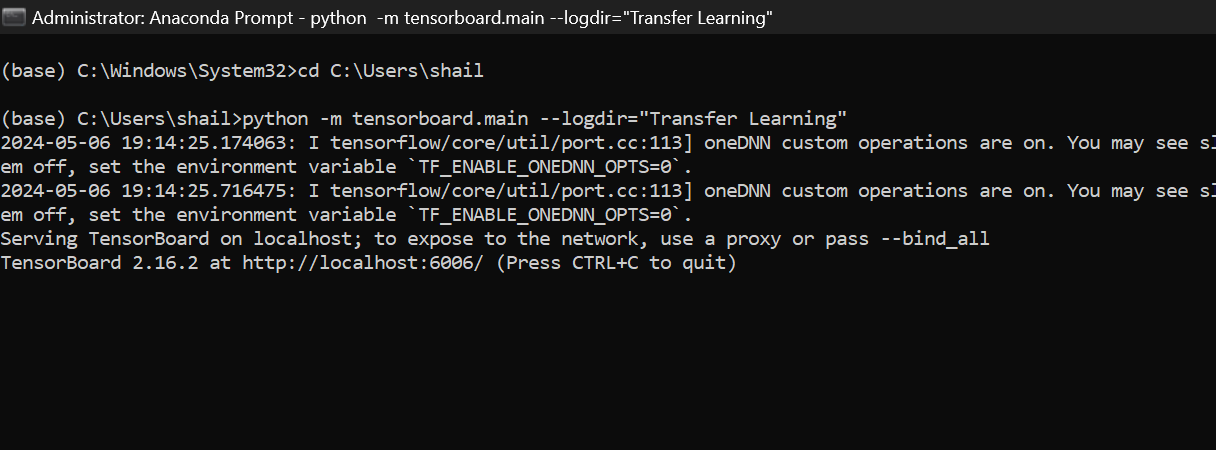

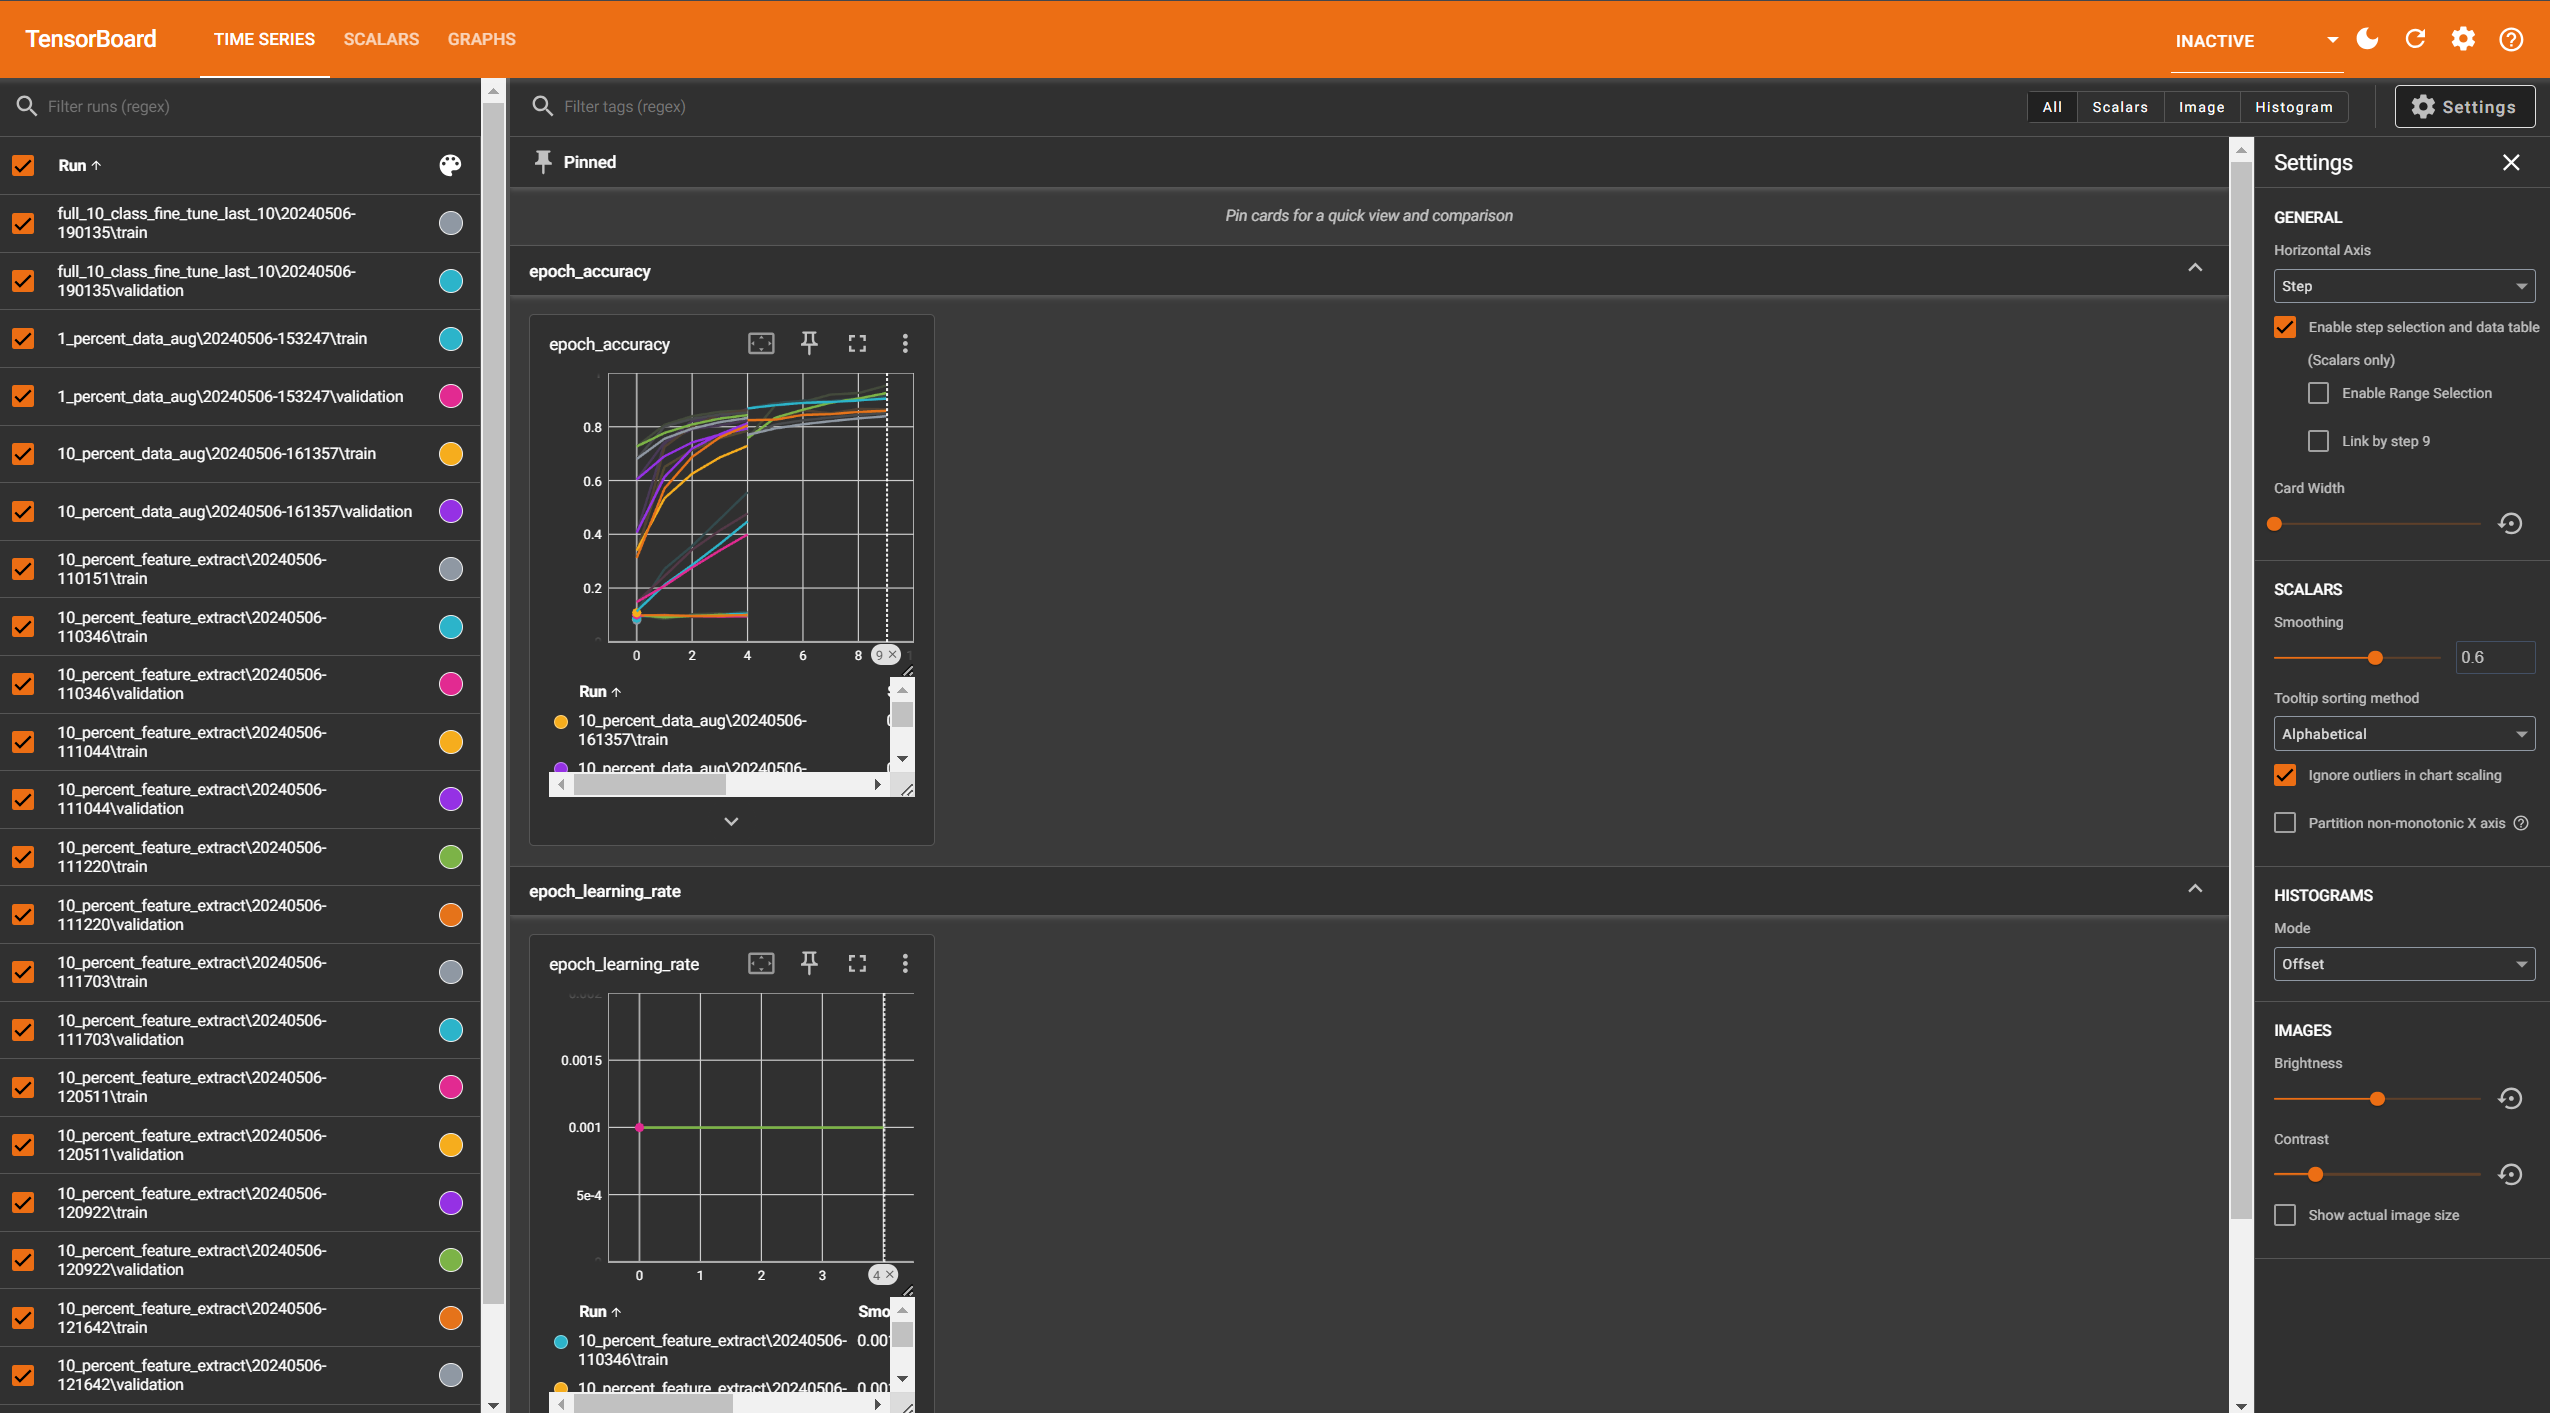